In [ ]:
import warnings; warnings.simplefilter('ignore')

import datetime as dts
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import pandas as pd
import requests
import zipfile as zi 
from sklearn import datasets, linear_model
import scipy.special as scsp
import statsmodels.api as sm
import math
from statsmodels.stats.proportion import proportions_ztest
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (10, 5)

In [2]:
df = pd.read_csv('data.csv', index_col=0, parse_dates=True)

<Axes: title={'center': 'Daily Returns'}, xlabel='Date'>

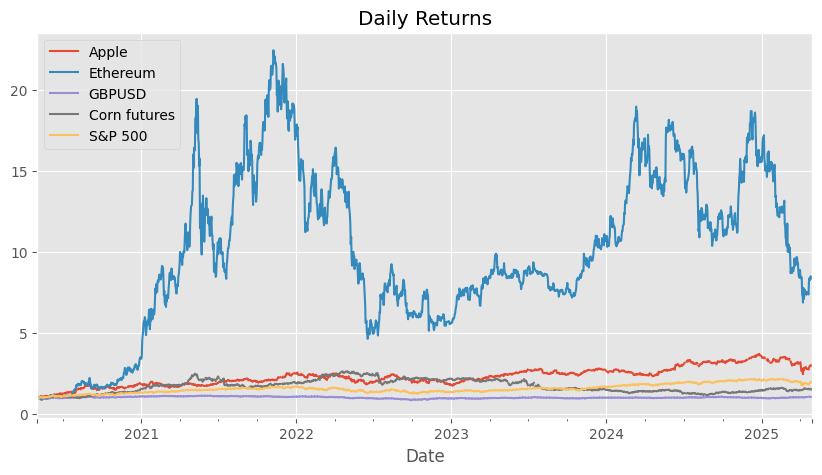

In [3]:
(df / df.iloc[0,:]).plot(title='Daily Returns', figsize=(10, 5), grid=True)

In [4]:
df_log_returns = np.log(df / df.shift(1))
df_log_returns = df_log_returns.dropna()

<Axes: xlabel='Date'>

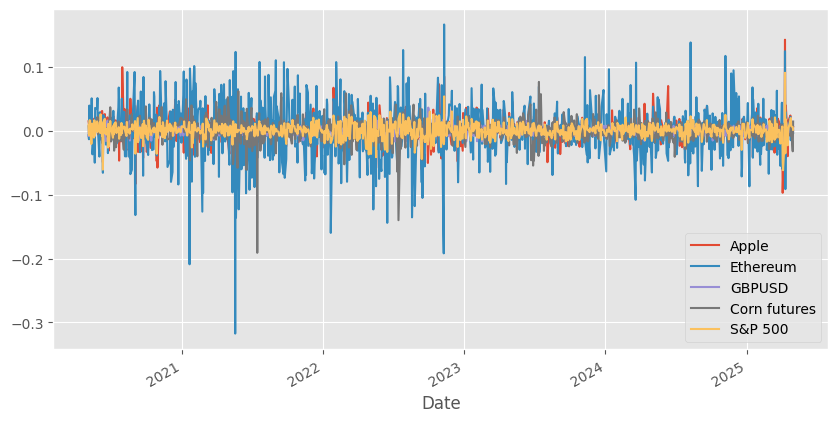

In [5]:
df_log_returns.plot()

In [7]:
from arch.univariate import ConstantMean, ARX, GARCH, EGARCH, ARCHInMean, StudentsT, Normal
from arch import arch_model

Results for Apple:
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                  Apple   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                2580.89
Distribution:                  Normal   AIC:                          -5153.77
Method:            Maximum Likelihood   BIC:                          -5134.22
                                        No. Observations:                  982
Date:                Mon, May 26 2025   Df Residuals:                      981
Time:                        19:43:39   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         1.2313e-03  7.082e-06    173

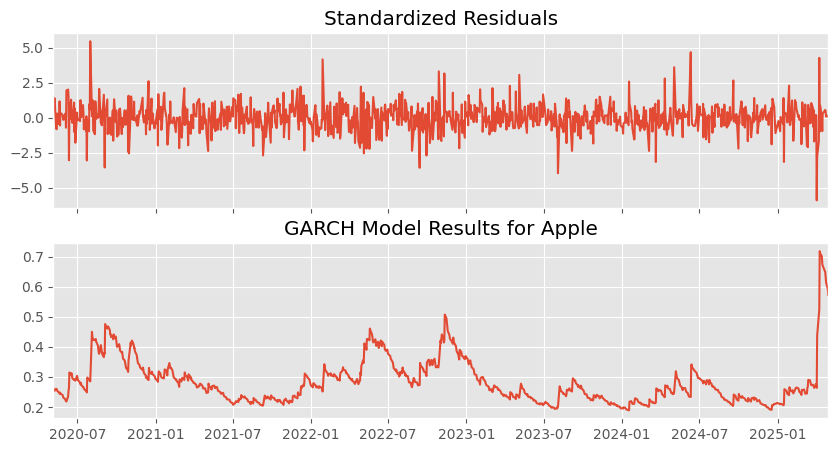

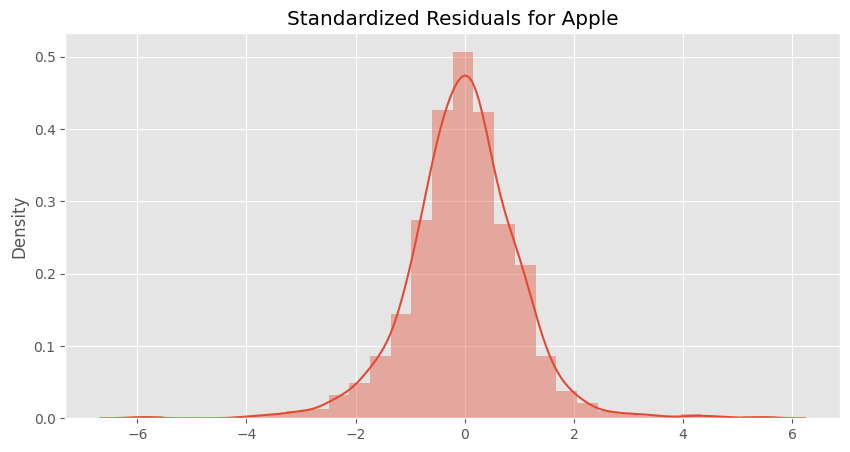

Results for Ethereum:
                     Constant Mean - GARCH Model Results                      
Dep. Variable:               Ethereum   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                1742.14
Distribution:                  Normal   AIC:                          -3476.27
Method:            Maximum Likelihood   BIC:                          -3456.72
                                        No. Observations:                  982
Date:                Mon, May 26 2025   Df Residuals:                      981
Time:                        19:43:40   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         6.8337e-04  1.215e-03 

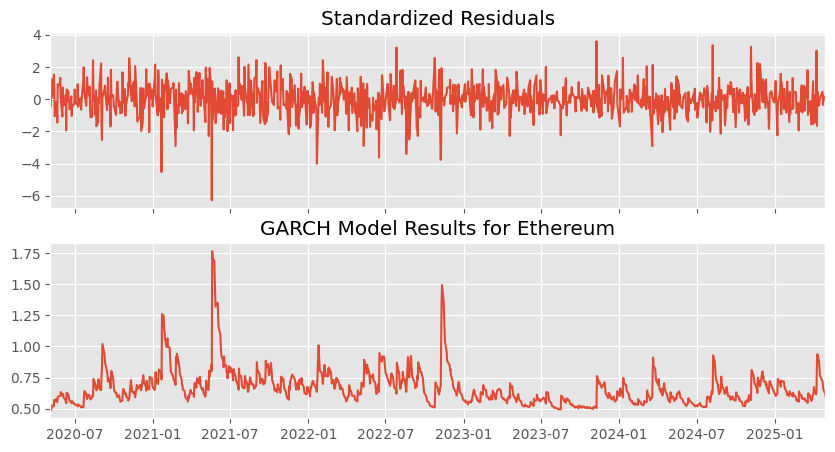

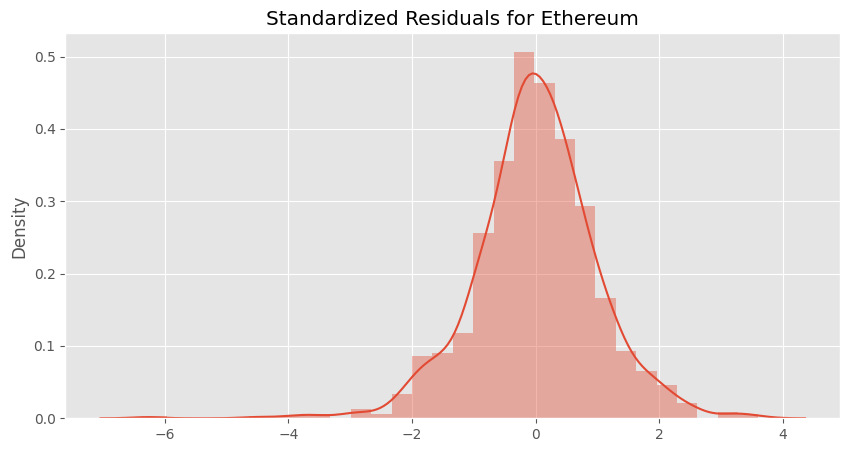

Results for GBPUSD:
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                 GBPUSD   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                3594.07
Distribution:                  Normal   AIC:                          -7180.14
Method:            Maximum Likelihood   BIC:                          -7160.58
                                        No. Observations:                  982
Date:                Mon, May 26 2025   Df Residuals:                      981
Time:                        19:43:41   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         2.2758e-04  3.952e-06     5

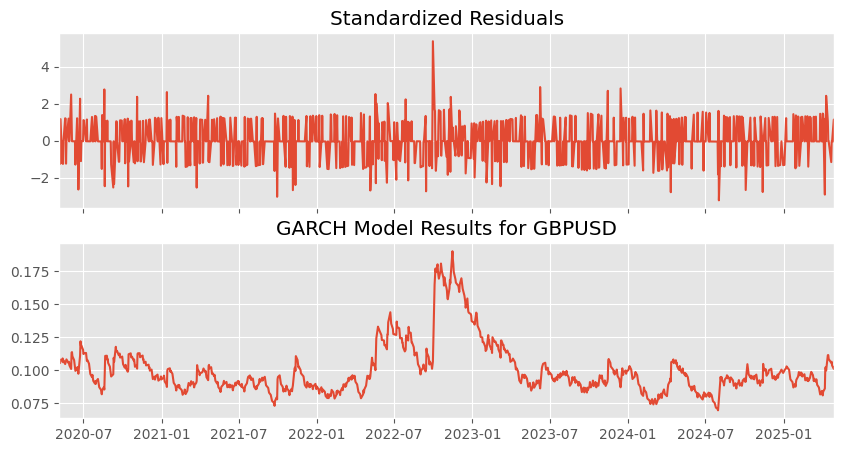

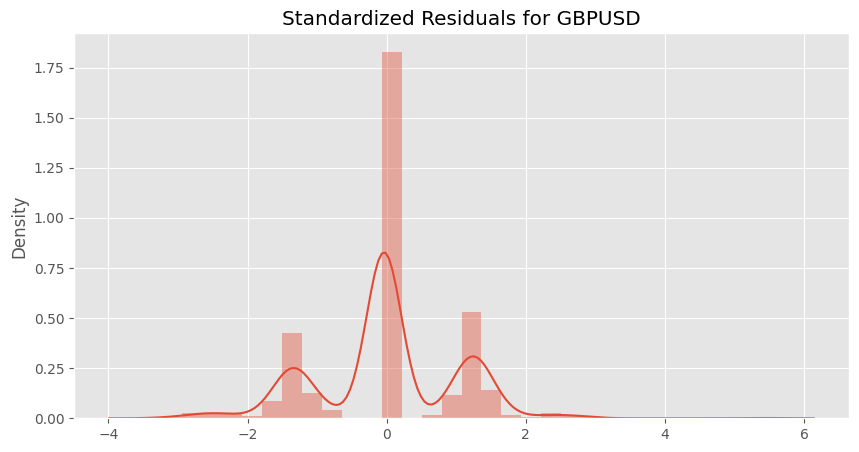

Results for Corn futures:
                     Constant Mean - GARCH Model Results                      
Dep. Variable:           Corn futures   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                2667.87
Distribution:                  Normal   AIC:                          -5327.73
Method:            Maximum Likelihood   BIC:                          -5308.17
                                        No. Observations:                  982
Date:                Mon, May 26 2025   Df Residuals:                      981
Time:                        19:43:43   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         2.1251e-04  3.427e

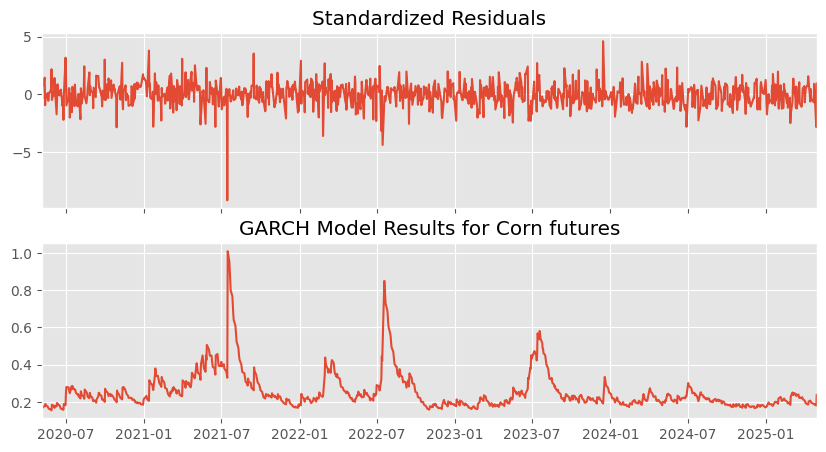

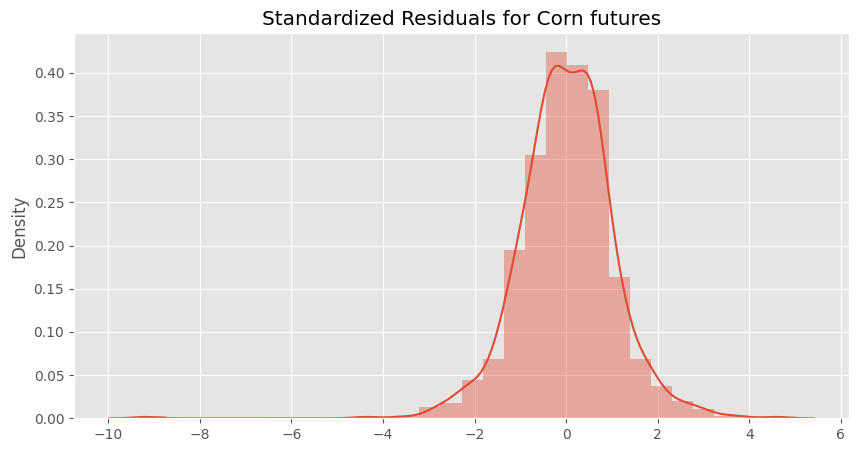

Results for S&P 500:
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                S&P 500   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                3084.32
Distribution:                  Normal   AIC:                          -6160.63
Method:            Maximum Likelihood   BIC:                          -6141.08
                                        No. Observations:                  982
Date:                Mon, May 26 2025   Df Residuals:                      981
Time:                        19:43:44   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         6.5485e-04  3.326e-04     

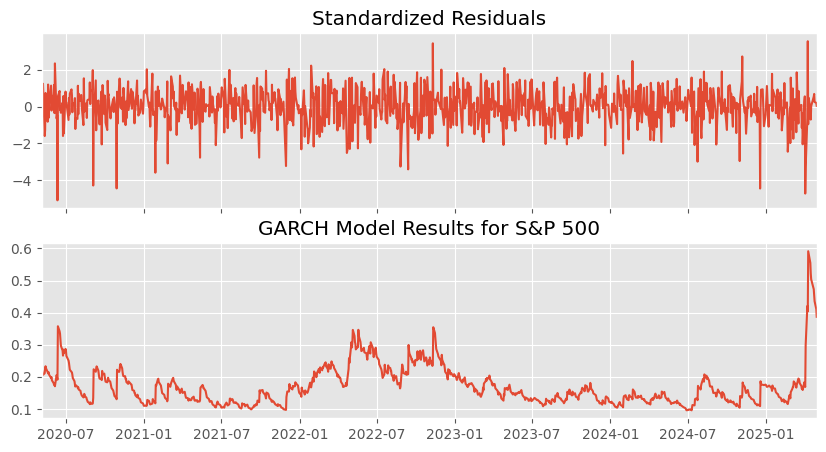

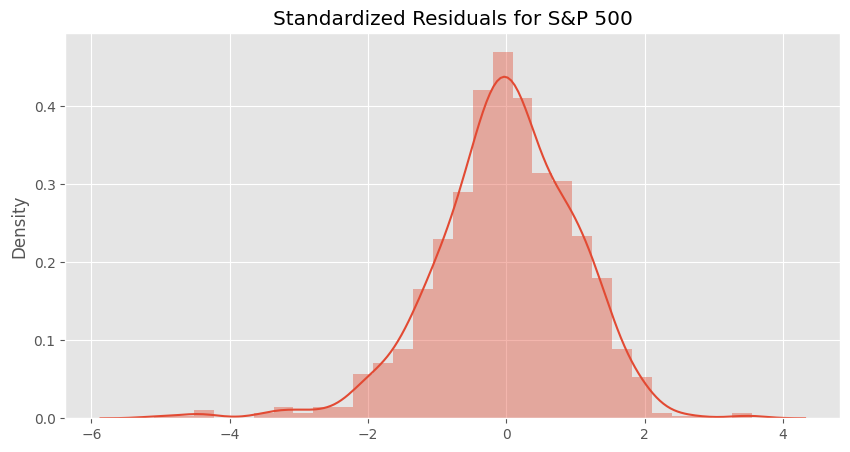

In [18]:
results = {}

for ticker in df_log_returns.columns:
    model = arch_model(df_log_returns[ticker], vol='Garch', p=1, q=1, dist='Normal')
    res = model.fit(disp='off')
    print(f"Results for {ticker}:")
    print(res.summary())
    
    res.plot(annualize='D')
    plt.title(f'GARCH Model Results for {ticker}')
    plt.show()
    
    # Plotting the standardized residuals
    sns.distplot(res.resid / res.conditional_volatility, bins=30, kde=True)
    plt.title(f'Standardized Residuals for {ticker}')
    plt.show()

    results[ticker] = res
    

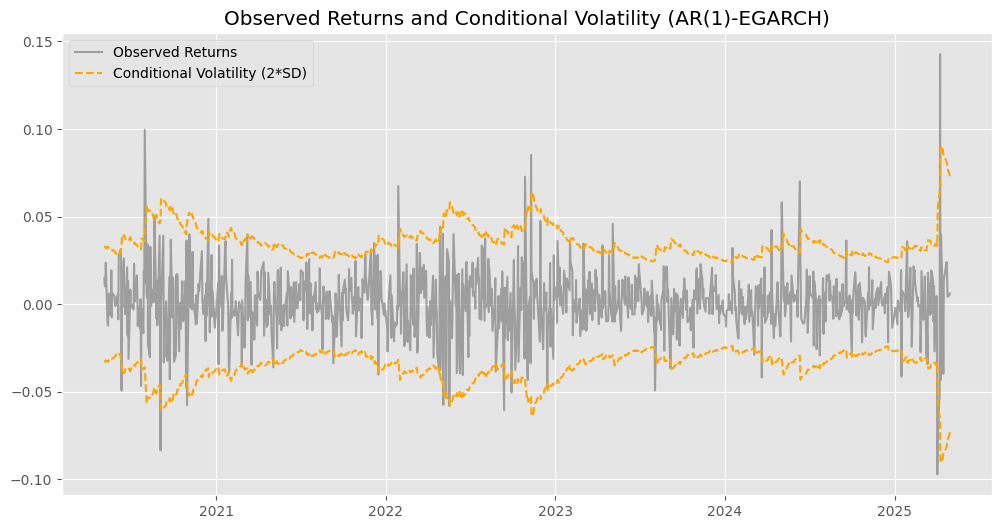

In [37]:
fig, ax = plt.subplots(figsize=(12, 6))

df_plot = df_log_returns[["Apple"]]
cond_var_plot = results["Apple"]

ax.plot(df_plot.dropna().index, 
        df_plot.dropna(), label='Observed Returns', color='grey', alpha=0.7)

ax.plot(cond_var_plot.conditional_volatility.index, 2 * cond_var_plot.conditional_volatility, label='Conditional Volatility (2*SD)', color='orange', linestyle='--')
ax.plot(cond_var_plot.conditional_volatility.index, -2 * cond_var_plot.conditional_volatility, color='orange', linestyle='--')

ax.set_title('Observed Returns and Conditional Volatility (AR(1)-EGARCH)')
ax.legend()
plt.show()

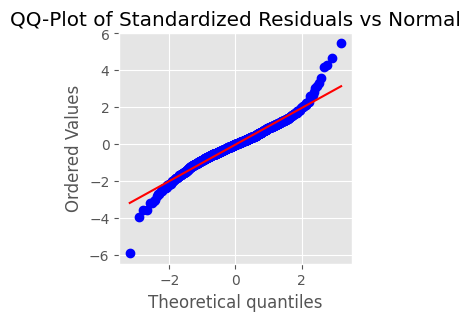

In [44]:
from scipy import stats
plt.figure(figsize=(3, 3))
stats.probplot(cond_var_plot.std_resid, dist="norm", plot=plt)
plt.title('QQ-Plot of Standardized Residuals vs Normal')
plt.show()

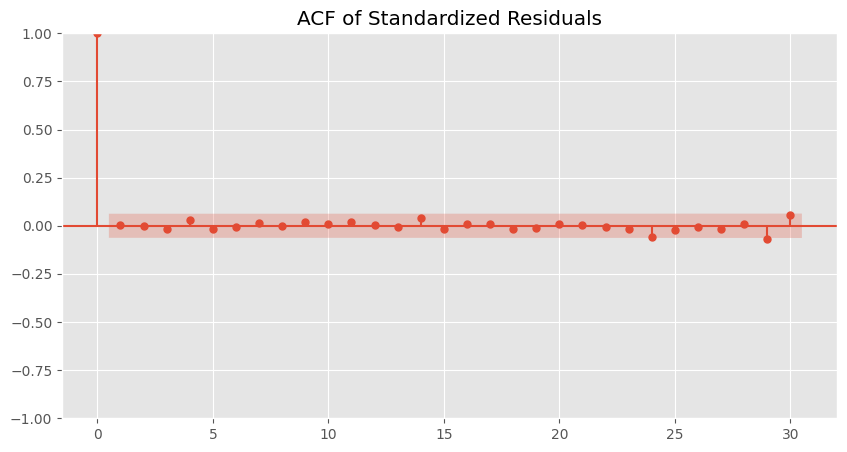

In [45]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, ax = plt.subplots(figsize=(10, 5))
plot_acf(cond_var_plot.std_resid, ax=ax, lags=30, title='ACF of Standardized Residuals')
plt.show()

____

### Basic code for portfolio 

In [49]:
portfolio = 0.2 * df_log_returns.mean(axis=1)

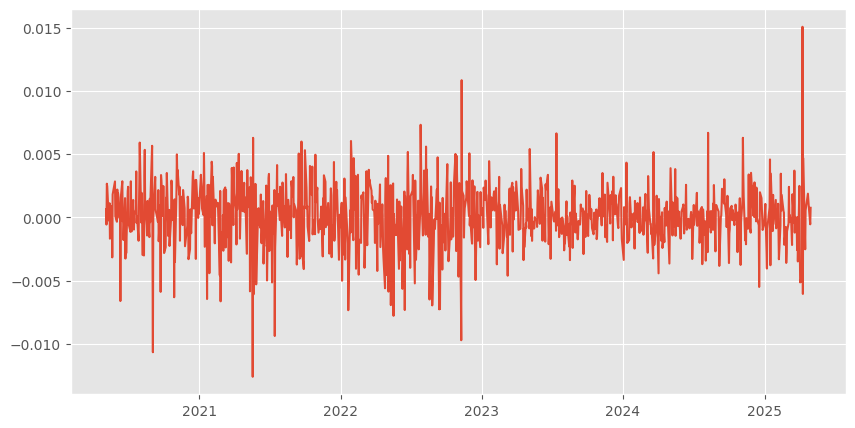

In [51]:
plt.plot(portfolio)

In [55]:
weights = np.array([0.2] * df.shape[1])  
log_rets = np.log(df / df.shift(1)).dropna()
port_rets = (log_rets * weights).sum(axis=1)

In [102]:
window   = 500
horizon  = 1
alpha    = 0.001

n       = len(port_rets)
var      = np.full(n, np.nan)
vol_pred = np.full(n, np.nan)

In [103]:
for t in range(window, n):
    train = port_rets.iloc[t-window:t]
    # fit GARCH(1,1) with normal errors
    am = arch_model(train, p=1, q=1, vol='Garch', dist='Normal')
    res = am.fit(disp='off')
    # one-step ahead forecast
    f = res.forecast(horizon=horizon, reindex=False)
    sigma_forecast = np.sqrt(f.variance.values[-1, :][0])
    vol_pred[t] = sigma_forecast
    # VaR = μ_forecast + σ_forecast * z_alpha; we assume zero mean
    var[t] = - (sigma_forecast * scipy.stats.norm.ppf(1-alpha))

# assemble results DataFrame
res_df = pd.DataFrame({
    'Ret':    port_rets,
    'Vol':    vol_pred,
    'VaR':    var
}, index=port_rets.index)

In [105]:
VaR_breached = res_df[res_df['Ret'].abs() > res_df['VaR'].abs()]

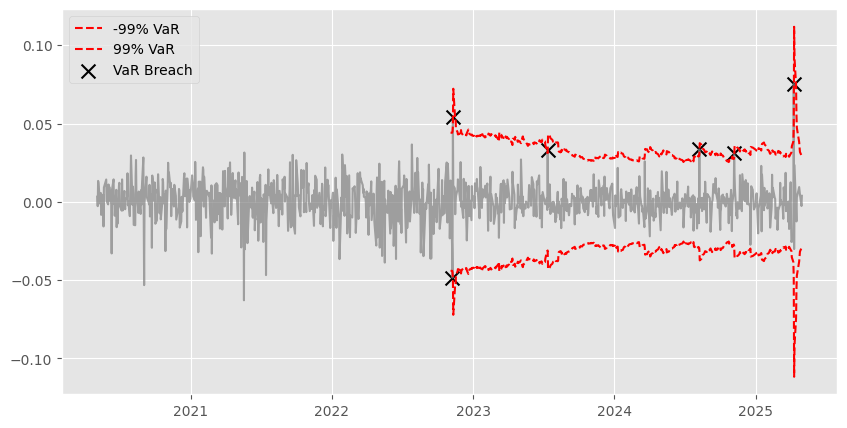

In [106]:
plt.plot(res_df['Ret'], color='grey', alpha=0.7)
plt.plot(-res_df['VaR'], label=f'-{int((1-alpha)*100)}% VaR', color='red', linestyle='--')
plt.plot(res_df['VaR'], label=f'{int((1-alpha)*100)}% VaR', color='red', linestyle='--')
plt.scatter(VaR_breached.index, VaR_breached.Ret, color='black', label='VaR Breach', marker='x',s = 100)
plt.legend()
plt.show()

In [77]:
from statsmodels.stats.proportion import proportions_ztest

In [95]:
exceptions = (res_df['Ret'] < -res_df['VaR']).astype(int)
n_exceptions = exceptions.sum()
n_tests = exceptions.count()
empirical_rate = n_exceptions / n_tests
theoretical_rate = alpha

stat, p_value = proportions_ztest(n_exceptions, n_tests, theoretical_rate, alternative='larger')

print(f"Number of observations: {n_tests}")
print(f"Number of exceptions:  {n_exceptions}")
print(f"Empirical exception rate: {empirical_rate:.4f}")
print(f"Theoretical rate:    {theoretical_rate:.4f}")
print(f"Kupiec POF test p-value:  {p_value:.4f}")

Number of observations: 982
Number of exceptions:  475
Empirical exception rate: 0.4837
Theoretical rate:    0.0100
Kupiec POF test p-value:  0.0000


VaR is bad. p-value < 0.05 means that the null hypothesis that VaR model is adequate shoudl be rejcted